# Introduction

In this project, we will be analyzing NYC Highschool data by looking at SAT scores across different schools. We will try to find indicators of higher SAT scores, such as the type of borough, type of race, level of safety, etc.

# Read in the data

In [20]:
# import libraries
import pandas as pd
import numpy as np
import re
import os

# make a list of files to read in
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

# write a loop to read in data files into empty dictionary
for f in data_files:
    d = pd.read_csv(r"C:\Users\abdi-\OneDrive\Documents\nychighschoolproject\{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [21]:
# read in survey files
all_survey = pd.read_csv(r"C:\Users\abdi-\OneDrive\Documents\nychighschoolproject\survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv(r"C:\Users\abdi-\OneDrive\Documents\nychighschoolproject\survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\abdi-\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


# Add DBN columns

In [22]:
# rename DBN column to dbn
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# define a function to add a 0 to csd values with only one digit
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# apply the function to a new csd column, and then add it to the school code column to get a cleaned dbn column
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [23]:
# convert some columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# calculate sat scores by adding the math, reading, and writing score
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# write a function to get the latitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# write a function to get the longitude
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# apply to a new column to get the lat and long in the dataframe, then convert to numeric dtype
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [24]:
# condense class size dataset to highschool students in general education
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "12-Sep"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# groupby and aggregate on the mean
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# select for the school year 2011-2012
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# select for cohort year 2006 and total cohort for demographic
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [25]:
# convert certain columns in the ap dataset to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [26]:
# merge all the datasets together
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [27]:
# write a function to get the school district from the dbn column
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [28]:
# calculate correlations between all columns and the SAT score
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [29]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

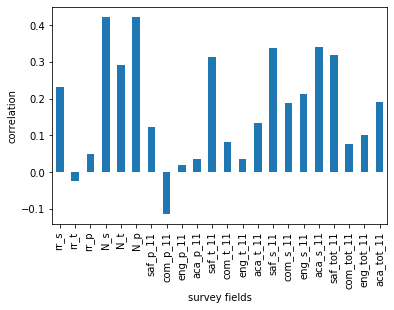

In [30]:
# import matplotlib.pyplot and plot a bar graph for the correlation between sat_score and the survey fields
import matplotlib.pyplot as plt
%matplotlib inline
surveycorr  = combined.corr()['sat_score'][survey_fields].plot(kind='bar')
plt.xlabel('survey fields')
plt.ylabel('correlation')
plt.show()

From the plot of the correlations between the survey field responses and the sat_scores, we can see that the N_s (number of student respondents) and N_p (number of teacher respondents) fields have the highest correlation (corr > 0.4). This seems to imply that the level of teacher and student engagement in terms of survey response indicates higher sat scores for the particular school.

Two other columns with strong positive correlations (corr > 0.3) with sat scores are the saf_t_11 (safety and respect scores based on teacher responses) and the saf_s_11 (safety adnd respect scores based on student responses) columns. We'll investigate this relationship a bit further.
    



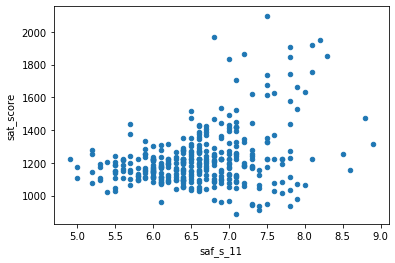

In [31]:
# plotting safety scores for saf_s_11 vs sat_score
safety = combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

While there seems to be a lot of data clumped together, as the student safety response increases (saf_s_11 > 7.5), there is also an increase in the sat_score. Lets look at a scatter plot for safety scores lower than 7.5.

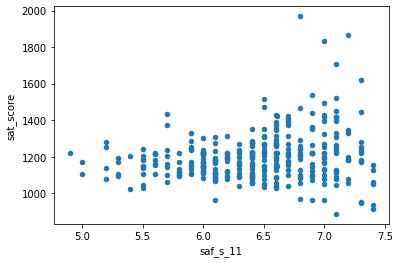

In [32]:
# plotting safety scores for saf_s_11 where saf_s_11 < 7.5
safetylow = combined[combined['saf_s_11'] < 7.5]
safetylowscatter = (combined[combined['saf_s_11'] < 7.5]).plot.scatter(x = 'saf_s_11', y = 'sat_score')

In [33]:
# get correlation between sat score and student safety response
safetylow.corr()['sat_score']['saf_s_11']

0.18966386937329896

After plotting student safety score responses (saf_s_11<7.5), and getting the correlation with sat_score, we can see that there isnt a strong correlation.
Our next step is to look at how safety scores vary by borough (region or district in NYC).

In [34]:
# group by the borough and aggregate on the mean value of the student safety scores
borosafety = combined.groupby('boro').agg(np.mean)['saf_s_11'].sort_values(ascending = False)
print(borosafety)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64


We find that by borough: 
- Manhattan has the highest average safety score at ~ 6.8 
- Brooklyn has the lowest at ~ 6.37.
The differences in student safety scores do not vary enough across the boroughs to make any firm judgement on the impact on SAT scores. We will now look at whether race is a factor in SAT score differences.

# Finding and plotting race correlations

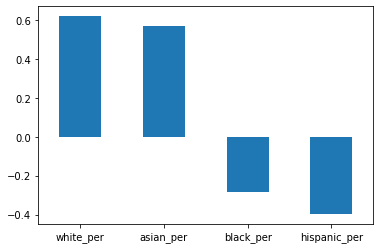

In [35]:
# plot race-related columns against sat_score
race_per = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][race_per].plot.bar(rot = 0)



From the bar graph, we can see that the percentage of whites and asians positively correlate with SAT scores, while black and hispanics negatively correlate. We will now look at schools with high hispanic percentages and low SAT scores to further look into the correlation with SAT scores.

-0.39698493078147196

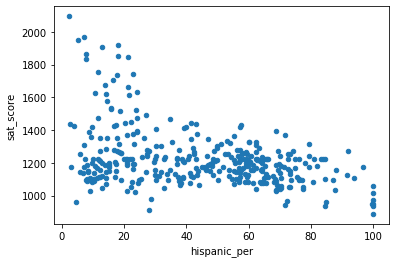

In [36]:
# plot percentage of hispanic students vs sat scores
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')

# calculate correlation coefficient
combined.corr()['sat_score']['hispanic_per']

Plotting hispanic percentages vs SAT scores shows a clearly negative correlation, and using the corr method gives us a value of ~ -0.4 to further validate our observation.

In [37]:
# select schools in the combined dataset with a hispanic_per > 95%
hispanichigh =  combined[combined['hispanic_per'] > 95]['SCHOOL NAME']
print(hispanichigh)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


There are 8 schools with a hispanic_per value greater than 95%. Upon further research, we find that these schools are catered to immigrants from Spanish speaking countries, which explains the high percentage of hispanic students.

In [38]:
# select schools with a hispanic_per < 10% and sat_score > 1800
hispanic_low = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']
print(hispanic_low)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


There are 5 schools with a hispanic_per value lower than 10%. After researching the schools, we find that these schools are top rated in the country, highly competitive, and require entrance exams from potential students.

# Finding and plotting gender correlations

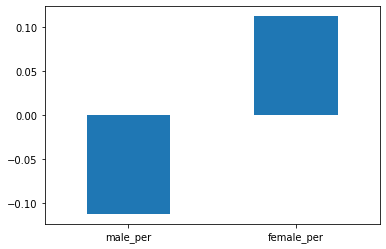

In [39]:
# plot correlations between gender and sat_score
gender_per = ['male_per','female_per']
combined.corr()['sat_score'][gender_per].plot.bar(rot=0)

From the graph, we can see that:
- the percentage of females in a school is positively correlated with SAT scores
- the percentage of males in a school is negatively correlated with SAT scores

We will now explore the relationship between female percentages and schools with high SAT scores.

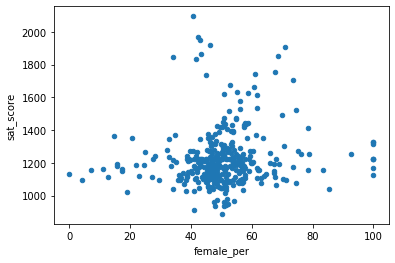

In [40]:
# select for schools with female_per > 60% and sat_score > 1700 
female_per_high  = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

# make a scatter plot to see if there is a correlation
combined.plot.scatter(x = 'female_per', y = 'sat_score')

From the above scatter plot, there is sort of a positive trend, but too many points clustered around the same sat_score across different female_per values for it to be conclusive. 

In [41]:
# select schools with a female_per > 60% and sat_score > 1700
female_per_high['SCHOOL NAME']


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From researching the selected schools, we find that they are centered towards the humanities and liberal arts.

# Finding and plotting AP test taker correlations

In [42]:
# make a new column (ap_per) by dividing # of AP test takers by total_enrollment
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

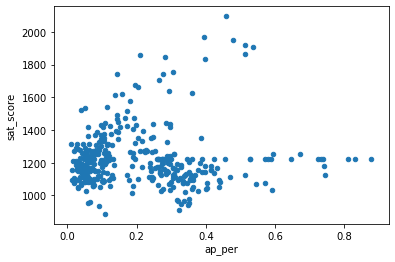

In [43]:
# make a scatter plot of ap_per vs sat_score
combined.plot.scatter(x = 'ap_per', y = 'sat_score')

The above scatter plot shows that there is no clear correlation between the percentage of students who have taken an AP exam and SAT scores. There is a large cluster of dots under 1400 sat score and between 0 to 40% for the ap_per variable, which indicates that there is not much of a correlation (corr ~ 0).

# Finding and plotting class sizes correlation 

0.3810143308095523

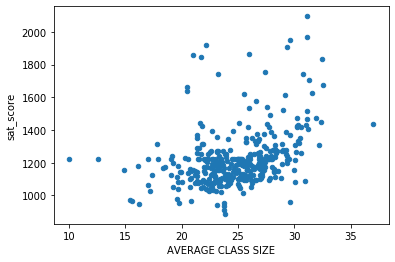

In [44]:
# make a scatter plot of average class sizes vs sat scores
combined.plot.scatter(x = 'AVERAGE CLASS SIZE', y = 'sat_score')

# use the corr method to calculate the correlation
combined.corr()['sat_score']['AVERAGE CLASS SIZE']

From plotting average class size vs sat scores, we can see that there is a positive trend, with a large cluster of points between average class sizes of 20-30 students. We find the correlation coefficient to be 0.38, which is considered to be a low positive correlation. Lets further explore variables related to class size.

0.24994890797549796

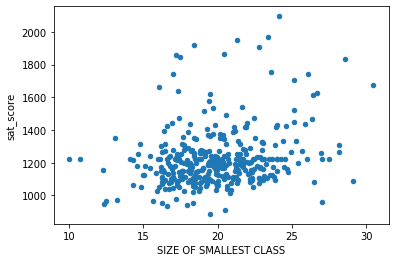

In [45]:
# make a plot of size of smallest class vs sat scores
combined.plot.scatter(x = 'SIZE OF SMALLEST CLASS', y = 'sat_score')
combined.corr()['sat_score']['SIZE OF SMALLEST CLASS']

0.31443428921262123

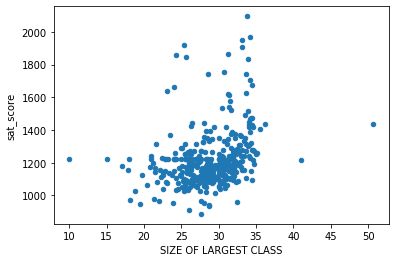

In [46]:
# make a plot of size of largest class vs sat scores
combined.plot.scatter(x = 'SIZE OF LARGEST CLASS', y = 'sat_score')
combined.corr()['sat_score']['SIZE OF LARGEST CLASS']

The plots tell us that the class size variable has a low positive correlation with SAT scores, as the correlation coefficient ranges from 0.25 - 0.38.

# Ranking Boroughs by Sale Price

We will now look at the relationship between schools with high SAT scores and the type of neighbourhood (in terms of property value). To do this, we will read in a dataset containing property values for the different boroughs, and go from there. You can find the dataset [here](https://www.kaggle.com/new-york-city/nyc-property-sales)

In [47]:
# read in property sales csv
property = pd.read_csv(r'C:\Users\abdi-\OneDrive\Documents\nychighschoolproject\nyc-rolling-sales.csv')
property.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


The dataset contains information on every building or building unit (apartment, etc.) sold in the New York City property market over a 12-month period. The borough column uses numbers to represent the boroughs used in the dataset. We will rename the column to match the 'boro' column in the combined dataset and replace the number with the borough names.

In [48]:
# write a dictionary to replace the coded names for the borough column
names = {1 : 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4 : 'Queens', 5 : 'Staten Island'}

# use replace method to change the value names 
property['BOROUGH'] = property['BOROUGH'].replace(names)
property['boro'] = property['BOROUGH'] 
property.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,boro
0,4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00,Manhattan
1,5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00,Manhattan
2,6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00,Manhattan
3,7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00,Manhattan
4,8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00,Manhattan


From looking at the table, the most important column for our analysis is the sale price column. We will determine the average sale price for each borough, and later compare that with the number of schools with high SAT scores. First we will need to clean the sale price column so we can work with it.

In [49]:
# replace - in columns with no value
property['SALE PRICE'] = property['SALE PRICE'].astype(str).str.replace('-','')

# convert sale price column to numeric data type
property['SALE PRICE'] = pd.to_numeric(property['SALE PRICE'], errors  = 'coerce')


In [50]:
property.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 23 columns):
Unnamed: 0                        84548 non-null int64
BOROUGH                           84548 non-null object
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
EASE-MENT                         84548 non-null object
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GR

In [51]:
property['SALE PRICE'].value_counts()

0.0          10228
10.0           766
450000.0       427
550000.0       416
650000.0       414
             ...  
5260000.0        1
1448094.0        1
2127500.0        1
734750.0         1
1038348.0        1
Name: SALE PRICE, Length: 10007, dtype: int64

The sale price column has about 15000 null values. Oddly enough, of the non-null values, 10000 are 0 values. According to the glossary of terms found in the dataset documentation, the sale price column consists of 0$ sale prices, which represents a transfer of ownership without cash considerration (i.e. parents giving property to children). Since the dataset contains all sales of property in New York over a 12 month period, we consider these 0 values to be an accurate representation, and will leave them as is.

boro
Bronx             590193
Brooklyn          834488
Manhattan        3337951
Queens            739908
Staten Island     543472
Name: SALE PRICE, dtype: int32

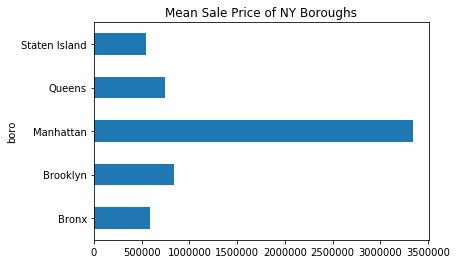

In [52]:
# calculate mean sale price per borough
mean_sale = property.groupby('boro').agg(np.mean)['SALE PRICE'].astype(int)
mean_sale.plot.barh(title = 'Mean Sale Price of NY Boroughs', x = 'Sale Price', y = 'Borough')
mean_sale

From the bar plot, we see that Manhattan has the highest average sale price, while the other four boroughs do not differ as much.

In [53]:
# groupby the borough to see average sat scores
combined_final = combined.copy()
combined_final.groupby('boro').agg(np.mean)['sat_score'].astype(int)

boro
Bronx            1157
Brooklyn         1181
Manhattan        1278
Queens           1286
Staten Island    1382
Name: sat_score, dtype: int32

# Comparing Survey Responses 

We now want to look at the difference between students, teachers, and parents responses to the surveys. The necessary columns we will use are:

safety and respect score 

saf_p_11
saf_s_11
saf_t_11

communication score

com_p_11
com_s_11
com_t_11

engagement score

eng_p_11
eng_s_11
eng_t_11

academic expectation score

aca_p_11
aca_s_11
aca_t_11

total score

saf_tot_11
com_tot_11
eng_tot_11
aca_tot_11

Lets make scatter plots of each category for students, teachers, and parents.

Text(0.5, 1.0, 'SAT Score vs Safety & Respect Score-Teachers')

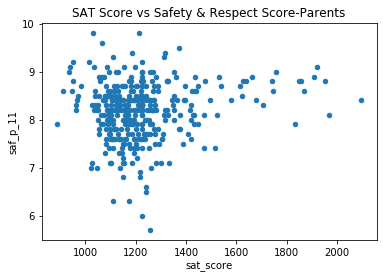

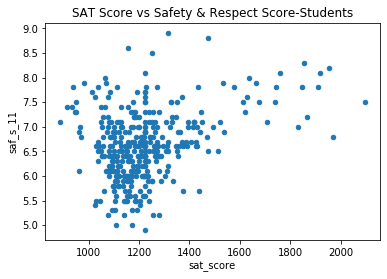

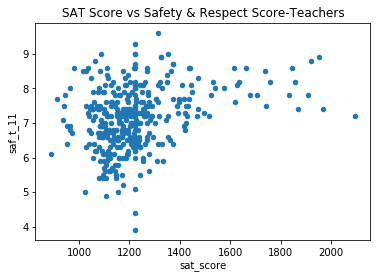

In [67]:
# plot safety and respect score responses vs sat scores

combined.plot.scatter(x =  'sat_score', y = 'saf_p_11')
plt.title('SAT Score vs Safety & Respect Score-Parents')

combined.plot.scatter(x =  'sat_score', y = 'saf_s_11')
plt.title('SAT Score vs Safety & Respect Score-Students')

combined.plot.scatter(x =  'sat_score', y = 'saf_t_11')
plt.title('SAT Score vs Safety & Respect Score-Teachers')

We can see that the safety and respect scores do not correlate very well with SAT scores. We can also see that parents give higher safety and respect scores than students, while teachers are somewhere in between.

Text(0.5, 1.0, 'SAT Score vs Communication Score-Teachers')

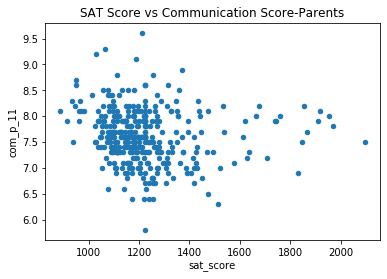

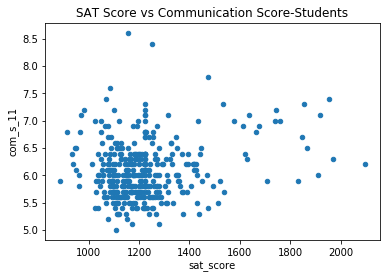

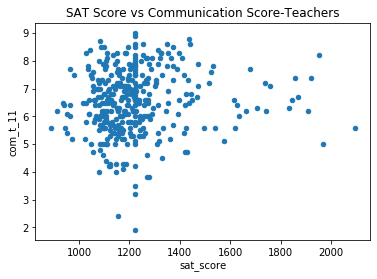

In [66]:
# plot communication score responses vs sat scores

combined.plot.scatter(x =  'sat_score', y = 'com_p_11')
plt.title('SAT Score vs Communication Score-Parents')

combined.plot.scatter(x =  'sat_score', y = 'com_s_11')
plt.title('SAT Score vs Communication Score-Students')

combined.plot.scatter(x =  'sat_score', y = 'com_t_11')
plt.title('SAT Score vs Communication Score-Teachers')

Teachers and parents give higher scores for communication, while students give lower scores as seen by the scatter plots. 

Text(0.5, 1.0, 'SAT Score vs Engagement Score-Teachers')

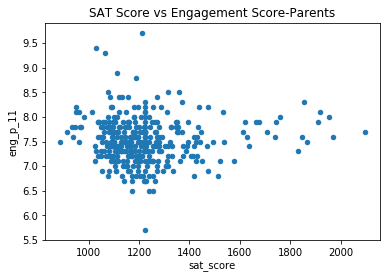

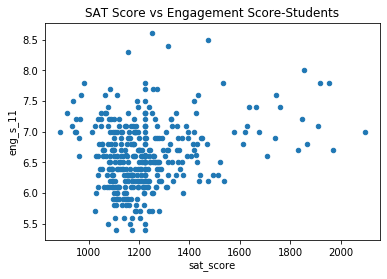

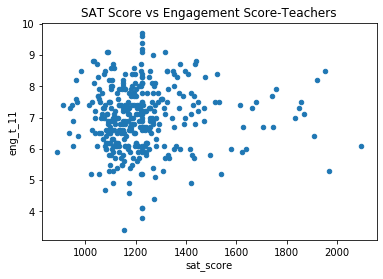

In [69]:
# plot engagement score responses vs sat scores

combined.plot.scatter(x =  'sat_score', y = 'eng_p_11')
plt.title('SAT Score vs Engagement Score-Parents')

combined.plot.scatter(x =  'sat_score', y = 'eng_s_11')
plt.title('SAT Score vs Engagement Score-Students')

combined.plot.scatter(x =  'sat_score', y = 'eng_t_11')
plt.title('SAT Score vs Engagement Score-Teachers')

Once again, we see that students give lower scores than their teacher and parent counterparts

Text(0.5, 1.0, 'SAT Score vs Academic Expectation Score-Teachers')

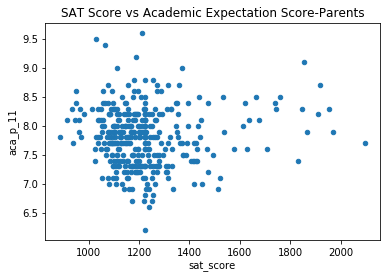

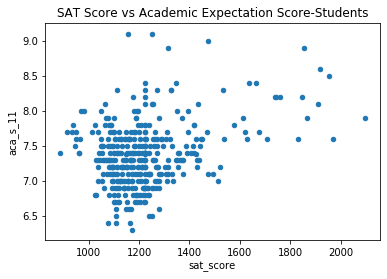

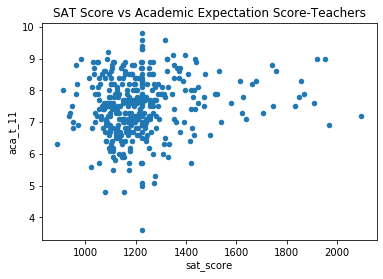

In [71]:
# plot academic expectation score responses vs sat scores

combined.plot.scatter(x =  'sat_score', y = 'aca_p_11')
plt.title('SAT Score vs Academic Expectation Score-Parents')

combined.plot.scatter(x =  'sat_score', y = 'aca_s_11')
plt.title('SAT Score vs Academic Expectation Score-Students')

combined.plot.scatter(x =  'sat_score', y = 'aca_t_11')
plt.title('SAT Score vs Academic Expectation Score-Teachers')

For academic expectation scores, we again see a similar trend with parents and teachers ranking much higher than students. From looking at all these survey response categories, we see that students have higher standards/lower expectations of their schools. 

# Creating Ranking System & Plotting Results

Now, we want to give a rank to schools based on their sat scores and survey responses. To do this, we will give a weight to each variable, and add them together. The columns we will use are:

sat_score  - 40%\
saf_tot_11 - 15%\
com_tot_11 - 15%\
eng_tot_11 - 15%\
aca_tot_11 - 15%

The weights given were based on perceived importance in determining overall school quality.

In [58]:
# calculate the weighted score
totalscore = .40*combined['sat_score'] + 0.15*combined['saf_tot_11'] + 0.15*combined['com_tot_11'] + 0.15*combined['eng_tot_11'] + 0.15*combined['aca_tot_11']
print(totalscore)

0      452.775
1      472.850
2      464.415
3      486.805
4      652.780
        ...   
358    465.215
359    418.515
360    428.185
361    531.280
362    426.425
Length: 363, dtype: float64


In [59]:
# divide the totalscore values to make a ranking system
totalscore.value_counts(bins=4)

(358.425, 479.855]    178
(479.855, 600.8]      160
(600.8, 721.745]       16
(721.745, 842.69]       9
dtype: int64

Text(0.5, 1.0, 'Mean Sale Price per Borough')

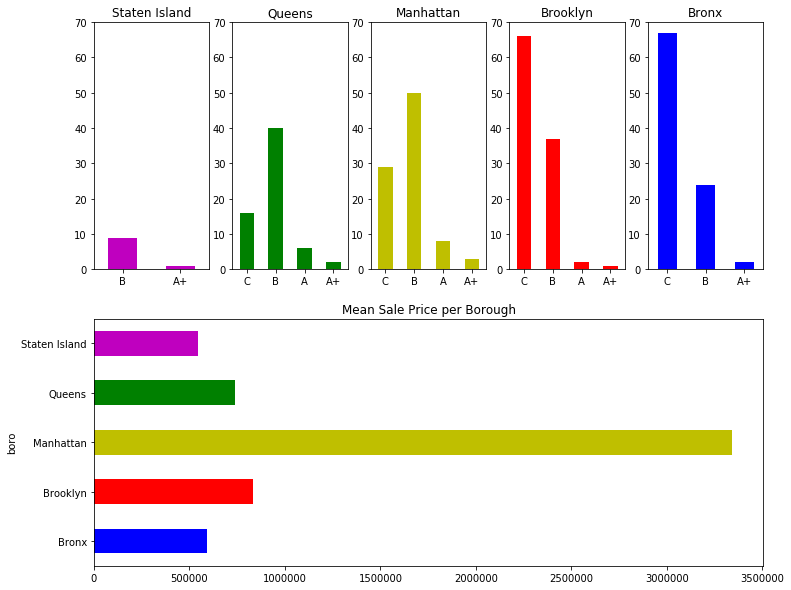

In [60]:
# write a function to return a rank based on the weighted score

def totalrank(a):
    if a >= 358.425 and a < 479.855:
        return 'C'
    elif a >= 479.855 and a < 600.8:
        return 'B'
    elif a >= 600.8 and a < 721.745:
        return 'A'
    elif a > 721.45:
        return 'A+'
    
# apply to the total score column

combined_final['rank'] = totalscore.apply(lambda x:totalrank(x))
combined_final['rank'] = combined_final['rank'].sort_values()


# select  for unique rank values for each borough

Manhattan = combined_final[combined_final['boro'] == 'Manhattan']['rank'].value_counts()
Bronx = combined_final[combined_final['boro'] == 'Bronx']['rank'].value_counts()
StatenIsland = combined_final[combined_final['boro'] == 'Staten Island']['rank'].value_counts()
Brooklyn = combined_final[combined_final['boro'] == 'Brooklyn']['rank'].value_counts()
Queens = combined_final[combined_final['boro'] == 'Queens']['rank'].value_counts()


# plot the rank counts for each borough, along with the mean price per borough for comparison

fig = plt.figure(figsize = (12,10)) 

ax1 = plt.subplot(2,5,1)
ax2 = plt.subplot(2,5,2)
ax3 = plt.subplot(2,5,3)
ax4 = plt.subplot(2,5,4)
ax5 = plt.subplot(2,5,5)
ax6 = plt.subplot(2,1,2)


Manhattan = Manhattan.reindex(index = ['C','B','A','A+'])
Queens = Queens.reindex(index = ['C','B','A','A+'])


ax1 = StatenIsland.plot.bar(ax = ax1,rot=0, color = 'm')
ax1.set_title('Staten Island')
ax1.set_ylim(0,70)

ax2 = Queens.plot.bar(ax = ax2,rot=0, color = 'g')
ax2.set_title('Queens')
ax2.set_ylim(0,70)

ax3 = Manhattan.plot.bar(ax = ax3,rot=0, color = 'y')
ax3.set_title('Manhattan')
ax3.set_ylim(0,70)

ax4 = Brooklyn.plot.bar(ax = ax4,rot=0, color = 'r')
ax4.set_title('Brooklyn')
ax4.set_ylim(0,70)

ax5 = Bronx.plot.bar(ax = ax5,rot=0, color = 'b')
ax5.set_title('Bronx')
ax5.set_ylim(0,70)




ax6 = mean_sale.plot.barh(ax = ax6,rot=0,color=['b','r','y','g','m'])
ax6.set_title('Mean Sale Price per Borough')




# Conclusion

In this project, we compiled data on New York City highschools, cleaned the data, made visualizations, and analyzed the data.
We looked at various factors affecting SAT scores, including race, class size, gender, and survey responses from parents, teachers, and students, etc. 

From plotting our final figure, we see that: 
    
    Of the five boroughs, Brooklyn and the Bronx have the highest amount of C ranked schools, while Manhattan and Queens come 2nd and 3rd, respectively. Staten Island has no C (or A) ranked schools, but doesnt have many high schools in total. 
    
    Manhattan has the highest average property sale price without question, and the rest of the boroughs are closer to each other in terms of average property sale price.
    
    Putting the number of highly ranked schools along with the mean sale price per borough into consideration, Queens seems to be the best borough overall, as there are a good number of higher ranked schools (B,A,A+), and the mean sale price is only higher than Staten Island (too small of a borough) and the Bronx (too many C ranked schools)